In [1]:
!pip install tensorflow deepxde matplotlib
%env DDE_BACKEND=tensorflow


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
env: DDE_BACKEND=tensorflow


In [2]:
import tensorflow as tf
import deepxde as dde
import numpy as np
import gc
SEED=0xdde2
%env DDE_BACKEND=tensorflow

2023-11-17 21:00:08.087110: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-17 21:00:08.116151: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-17 21:00:08.116178: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-17 21:00:08.116200: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-17 21:00:08.121141: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-17 21:00:08.121565: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

env: DDE_BACKEND=tensorflow


In [3]:
def f1(x):
    return x * np.sin(5 * x)

In [4]:
#Landscapeviz code for ease of changing to work with deepxde
#originally from here https://github.com/artur-deluca/landscapeviz/tree/master
import logging
import gc
import os

import h5py
import numpy as np
import tensorflow as tf
from sklearn.decomposition import PCA

# from .trajectory import load_weights, weight_encoder


def get_vectors(model, seed=None, trajectory=None):

    np.random.seed(seed)
    vector_x, vector_y = list(), list()
    weights = model.get_weights()

    if trajectory:
        # this has to be re-written
        load_weights(model, trajectory)
        file_path = os.path.join(trajectory, ".trajectory", "model_weights.hdf5")

        with h5py.File(file_path, "r+") as f:
            differences = list()
            trajectory = np.array(f["weights"])
            for i in range(0, len(trajectory) - 1):
                differences.append(trajectory[i] - trajectory[-1])

            pca = PCA(n_components=2)
            pca.fit(np.array(differences))
            f["X"], f["Y"] = pca.transform(np.array(differences)).T

        vector_x = weight_encoder(model, pca.components_[0])
        vector_y = weight_encoder(model, pca.components_[1])

        return weights, vector_x, vector_y

    else:
        cast = np.array([1]).T
        for layer in weights:
            # set standard normal parameters
            # filter-wise normalization
            k = len(layer.shape) - 1
            d = np.random.multivariate_normal([0], np.eye(1), layer.shape).reshape(
                layer.shape
            )
            dist_x = (
                d / (1e-10 + cast * np.linalg.norm(d, axis=k))[:, np.newaxis]
            ).reshape(d.shape)

            vector_x.append(
                (
                    dist_x * (cast * np.linalg.norm(layer, axis=k))[:, np.newaxis]
                ).reshape(d.shape)
            )

            d = np.random.multivariate_normal([0], np.eye(1), layer.shape).reshape(
                layer.shape
            )
            dist_y = (
                d / (1e-10 + cast * np.linalg.norm(d, axis=k))[:, np.newaxis]
            ).reshape(d.shape)

            vector_y.append(
                (
                    dist_y * (cast * np.linalg.norm(layer, axis=k))[:, np.newaxis]
                ).reshape(d.shape)
            )
        gc.collect()
        return weights, vector_x, vector_y


def _obj_fn(model, data, solution):

    old_weights = model.get_weights()
    model.set_weights(solution)
    value = model.evaluate(data[0], data[1], verbose=0)
    model.set_weights(old_weights)

    return value


def build_mesh(
    model,
    data,
    grid_length,
    extension=1,
    filename="meshfile",
    verbose=True,
    seed=None,
    trajectory=None,
    predicted=None
):

    logging.basicConfig(level=logging.INFO)

    Z = list()

    # get vectors and set spacing
    origin, vector_x, vector_y = get_vectors(model, seed=seed, trajectory=trajectory)
    space = np.linspace(-extension, extension, grid_length)

    X, Y = np.meshgrid(space, space)

    for i in range(grid_length):
        if verbose:
            logging.info("line {} out of {}".format(i, grid_length))

        for j in range(grid_length):
            solution = [
                origin[x] + X[i][j] * vector_x[x] + Y[i][j] * vector_y[x]
                for x in range(len(origin))
            ]

            Z.append(_obj_fn(model, data, solution))
        gc.collect()
    gc.collect()
    Z = np.array(Z)
    os.makedirs("./files", exist_ok=True)

    with h5py.File("./files/{}.hdf5".format(filename), "w") as f:
        f["space"] = space
        original_results = _obj_fn(model, data, origin)
        f["original_" + "MSE"] = original_results
        f["MSE"] = Z.reshape(X.shape)
        if type(predicted) != type(None):
            f['X_TEST'] = predicted[0]
            f['Y_TEST_PREDICTED'] = predicted[1]
        f.close()

    del Z
    gc.collect()
import h5py
import os
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d import Axes3D

FILENAME = "./files/meshfile.hdf5"


def _fetch_data(key, filename):

    if filename[-5:] != ".hdf5":
        filename += ".hdf5"

    with h5py.File(filename, "r") as f:
        space = np.asarray(f["space"])
        Z = np.array(f[key])

    X, Y = np.meshgrid(space, space)
    return X, Y, Z


def plot_contour(
    key, lines=(.0001, 1, 25), trajectory=None, filename=FILENAME, save=None, title=None,
):

    X, Y, Z = _fetch_data(key, filename)

    fig, ax = plt.subplots()
    CS = ax.contour(X, Y, Z, cmap="jet", levels=np.linspace(lines[0], lines[1], lines[2]))
    ax.clabel(CS, inline=1, fontsize=8)

    if trajectory:
        with h5py.File(
            os.path.join(trajectory, ".trajectory", "model_weights.hdf5"), "r"
        ) as f:
            ax.plot(np.array(f["X"]), np.array(f["Y"]), marker=".")
    if title != None:
        plt.title(label=title)
    fig.patch.set_facecolor('white')

    if save:
        fig.savefig(save)

    plt.show()


def plot_grid(key, filename=FILENAME, save=None, title=None):
    X, Y, Z = _fetch_data(key, filename)
    fig, _ = plt.subplots()

    plt.imshow(
        Z, interpolation="none", cmap='jet', extent=[X.min(), X.max(), Y.min(), Y.max()]
    )
    plt.colorbar()
    if title != None:
        plt.title(label=title)
    fig.patch.set_facecolor('white')

    if save:
        fig.savefig(save)

    plt.show()


def plot_3d(key, filename=FILENAME, log=False, save=None, title=None):

    X, Y, Z = _fetch_data(key, filename)

    if log:
        Z = np.log(Z + 0.1)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    # Plot the surface.
    surf = ax.plot_surface(
        X, Y, Z, cmap='jet', linewidth=0, antialiased=False
    )
    fig.colorbar(surf, shrink=0.5, aspect=5)
    if title != None:
        plt.title(label=title)
    fig.patch.set_facecolor('white')
    if save:
        fig.savefig(save)

    plt.show()

# Now try to make a 16 bit FNN with the same weights as a 32 bit FNN (just truncated)
Having a determinstic random seed is not enough; we need the weights (and the loss landscape) to start the same so that we can see how (any why) they diverge.

Set the default float type to float32
Compiling model...
'compile' took 0.002676 s

Set the default float type to float16
Compiling model...
'compile' took 0.002741 s

Set the default float type to float16
Compiling model...
'compile' took 0.001005 s



/home/jacob/dev/lu-group/mixed-precision-sciml/.direnv/python-3.10/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


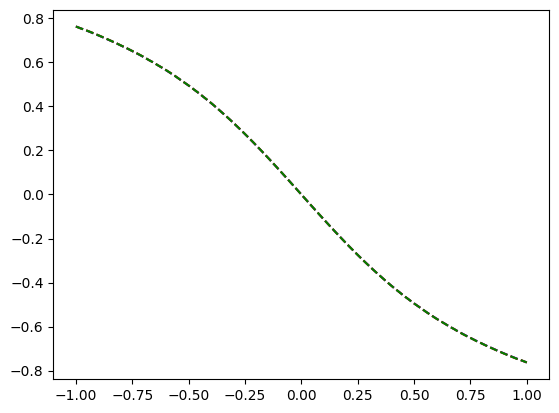

In [5]:
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)
import tensorflow as tf
dde.config.set_random_seed(SEED)
#
# Create the original model as float32
#
dde.config.set_default_float('float32')

geom = dde.geometry.Interval(-1, 1)
data = dde.data.Function(geom, f1, 16, 100)

net = dde.nn.FNN([1] + [10] * 2 + [1], "tanh", "Glorot uniform")
model32_to_copy = dde.Model(data, net)
model32_to_copy.compile("adam", lr=0.001, metrics=["l2 relative error"])
# print the original weights
# generate the test arrays
_ = model32_to_copy.data.test()
# do one evaluation to initialize the weights
_ = model32_to_copy.predict([[1]])


#
# create a new model, but float16
#
dde.config.set_default_float('float16')

geom = dde.geometry.Interval(-1, 1)
data = dde.data.Function(geom, f1, 16, 100)

net = dde.nn.FNN([1] + [10] * 2 + [1], "tanh", "Glorot uniform")
model16_new = dde.Model(data, net)
model16_new.compile("adam", lr=0.001, metrics=["l2 relative error"])

# generate the test arrays
_ = model16_new.data.test()
# do one evaluation to initialize the weights
_ = model16_new.predict([[1]])
# copy the weights
for i, layer in enumerate(model32_to_copy.net.denses):
    model16_new.net.denses[i].set_weights([tf.cast(w, dtype=tf.float16) for w in layer.get_weights()])
#
# create a new model, but mixed
#
dde.config.set_default_float('float16')
tf.keras.mixed_precision.set_global_policy("mixed_float16")

geom = dde.geometry.Interval(-1, 1)
data = dde.data.Function(geom, f1, 16, 100)

net = dde.nn.FNN([1] + [10] * 2 + [1], "tanh", "Glorot uniform")
modelmixed_new = dde.Model(data, net)
modelmixed_new.compile("adam", lr=0.001, metrics=["l2 relative error"])

# generate the test arrays
_ = modelmixed_new.data.test()
# do one evaluation to initialize the weights
_ = modelmixed_new.predict([[1]])
# copy the weights
for i, layer in enumerate(model32_to_copy.net.denses):
    modelmixed_new.net.denses[i].set_weights([tf.cast(w, dtype=tf.float32) for w in layer.get_weights()])


# make sure it worked by plotting the function with no training; should be the same as the first plot; they should overlap perfectly
plt.plot(model32_to_copy.data.test_x, model32_to_copy.predict(model32_to_copy.data.test_x), 'b--')
plt.plot(model16_new.data.test_x, model16_new.predict(model16_new.data.test_x), 'r--')
plt.plot(modelmixed_new.data.test_x, modelmixed_new.predict(modelmixed_new.data.test_x), 'g--')
plt.show()
class SaveLosslandscapeCallback(dde.callbacks.Callback):
    def __init__(self, name, store, resolution=50, measure_on=[0,1,1500,5000]):
        super().__init__()
        self.name = name
        self.resolution = resolution
        self.measure_on = measure_on
        self.epoch_on = 0
        self.store = store
    def on_epoch_begin(self):
        if self.epoch_on in self.measure_on:
            from deepxde import losses
            mse = losses.get("MSE")
            self.model.net.compile(loss=mse)
            self.model.net.loss = "MSE"
            print(f'\nGENERATING mesh before {self.epoch_on}...; saving to ./files/{self.name}_epoch_{self.epoch_on}.hdf5\n')
            build_mesh(
                self.model.net,(self.model.data.train_x,self.model.data.train_y),
                grid_length=self.resolution,seed=SEED,verbose=False,extension=1,
                filename=f"{self.name}_epoch_{self.epoch_on}",
                predicted=(self.model.data.test_x, self.model.predict(self.model.data.test_x))
            )
            gc.collect()
        self.epoch_on += 1
    def on_train_end(self):
        """
        We put the file locations in the shared store
        """
        self.store[self.name] = [f"./files/{self.name}_epoch_{e}.hdf5" for e in self.measure_on]
global_store = {}

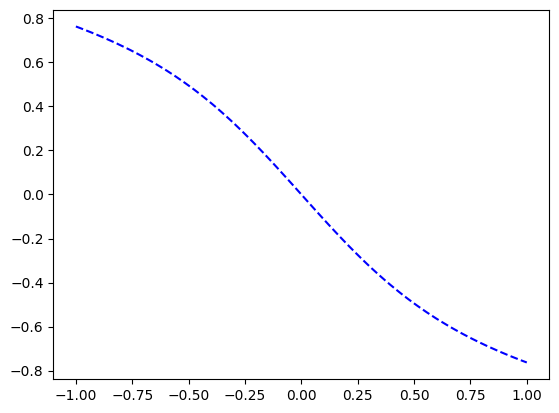

Set the default float type to float32
Set the default float type to float32
Training model...

Step      Train loss    Test loss     Test metric   
0         [5.22e-01]    [4.68e-01]    [1.50e+00]    

GENERATING mesh before 0...; saving to ./files/float 32_epoch_0.hdf5


GENERATING mesh before 1...; saving to ./files/float 32_epoch_1.hdf5

400       [6.80e-02]    [6.65e-02]    [5.64e-01]    
800       [3.85e-02]    [4.06e-02]    [4.41e-01]    
1200      [3.03e-02]    [3.21e-02]    [3.92e-01]    

GENERATING mesh before 1500...; saving to ./files/float 32_epoch_1500.hdf5

1600      [2.19e-02]    [2.29e-02]    [3.31e-01]    
2000      [6.54e-03]    [6.91e-03]    [1.82e-01]    
2400      [5.10e-04]    [5.59e-04]    [5.17e-02]    
2800      [3.14e-04]    [3.51e-04]    [4.10e-02]    
3200      [2.28e-04]    [2.56e-04]    [3.50e-02]    
3600      [1.82e-04]    [2.04e-04]    [3.12e-02]    
4000      [1.55e-04]    [1.75e-04]    [2.89e-02]    
4400      [1.35e-04]    [1.56e-04]    [2.74e-02]  

In [6]:
plt.plot(model32_to_copy.data.test_x, model32_to_copy.predict(model32_to_copy.data.test_x), 'b--')
plt.show()

dde.config.set_default_float('float32')
model32_to_copycallbacks = [SaveLosslandscapeCallback(store=global_store, name="float 32")]
dde.config.set_default_float('float32')
losshistory, train_state = model32_to_copy.train(iterations=10_000, callbacks=model32_to_copycallbacks,display_every=400)

Set the default float type to float16


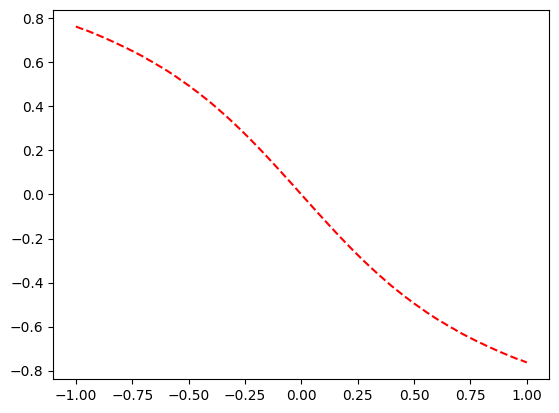

Training model...

Step      Train loss    Test loss     Test metric   
0         [5.22e-01]    [4.69e-01]    [1.50e+00]    

GENERATING mesh before 0...; saving to ./files/float 16_epoch_0.hdf5


GENERATING mesh before 1...; saving to ./files/float 16_epoch_1.hdf5

400       [7.73e-02]    [7.33e-02]    [5.92e-01]    
800       [5.18e-02]    [5.24e-02]    [5.01e-01]    
1200      [4.08e-02]    [4.25e-02]    [4.51e-01]    

GENERATING mesh before 1500...; saving to ./files/float 16_epoch_1500.hdf5

1600      [2.83e-02]    [3.00e-02]    [3.79e-01]    
2000      [2.10e-02]    [2.19e-02]    [3.24e-01]    
2400      [1.18e-02]    [1.24e-02]    [2.44e-01]    
2800      [3.15e-03]    [3.30e-03]    [1.26e-01]    
3200      [1.96e-03]    [1.99e-03]    [9.76e-02]    
3600      [1.60e-03]    [1.62e-03]    [8.81e-02]    
4000      [1.39e-03]    [1.42e-03]    [8.24e-02]    
4400      [1.22e-03]    [1.23e-03]    [7.67e-02]    
4800      [1.06e-03]    [1.08e-03]    [7.18e-02]    

GENERATING mesh bef

In [7]:
dde.config.set_default_float('float16')

plt.plot(model16_new.data.test_x, model16_new.predict(model16_new.data.test_x), 'r--')
plt.show()

model16_newcallbacks = [SaveLosslandscapeCallback(store=global_store, name="float 16")]
losshistory, train_state = model16_new.train(iterations=10_000, callbacks=model16_newcallbacks,display_every=400)

Set the default float type to float16


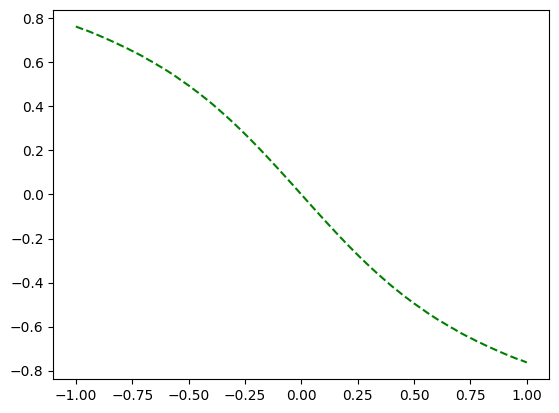

Training model...

Step      Train loss    Test loss     Test metric   
0         [5.22e-01]    [4.69e-01]    [1.50e+00]    

GENERATING mesh before 0...; saving to ./files/mixed float 16_epoch_0.hdf5


GENERATING mesh before 1...; saving to ./files/mixed float 16_epoch_1.hdf5

25        [2.54e-01]    [2.27e-01]    [1.04e+00]    
50        [2.10e-01]    [1.85e-01]    [9.41e-01]    
75        [1.97e-01]    [1.74e-01]    [9.14e-01]    
100       [1.84e-01]    [1.63e-01]    [8.84e-01]    
125       [1.71e-01]    [1.52e-01]    [8.53e-01]    
150       [1.57e-01]    [1.41e-01]    [8.20e-01]    
175       [1.44e-01]    [1.29e-01]    [7.87e-01]    
200       [1.32e-01]    [1.19e-01]    [7.54e-01]    
225       [1.20e-01]    [1.09e-01]    [7.23e-01]    
250       [1.09e-01]    [1.00e-01]    [6.93e-01]    
275       [1.00e-01]    [9.24e-02]    [6.66e-01]    
300       [9.15e-02]    [8.56e-02]    [6.40e-01]    
325       [8.42e-02]    [7.97e-02]    [6.18e-01]    
350       [7.81e-02]    [7.47e-0

In [8]:
dde.config.set_default_float('float16')
tf.keras.mixed_precision.set_global_policy("mixed_float16")

plt.plot(modelmixed_new.data.test_x, modelmixed_new.predict(modelmixed_new.data.test_x), 'g--')
plt.show()

modelmixed_newcallbacks = [SaveLosslandscapeCallback(store=global_store, name="mixed float 16")]
losshistory, train_state = modelmixed_new.train(iterations=10_000, callbacks=modelmixed_newcallbacks,display_every=25)

In [9]:
import json
# print(json.dumps(global_store))
# instead of generating it again, we just load the previous files
global_store = json.loads('{"float 32": ["./files/float 32_epoch_0.hdf5", "./files/float 32_epoch_1.hdf5", "./files/float 32_epoch_1500.hdf5", "./files/float 32_epoch_5000.hdf5"], "float 16": ["./files/float 16_epoch_0.hdf5", "./files/float 16_epoch_1.hdf5", "./files/float 16_epoch_1500.hdf5", "./files/float 16_epoch_5000.hdf5"], "mixed float 16": ["./files/mixed float 16_epoch_0.hdf5", "./files/mixed float 16_epoch_1.hdf5", "./files/mixed float 16_epoch_1500.hdf5", "./files/mixed float 16_epoch_5000.hdf5"]}')

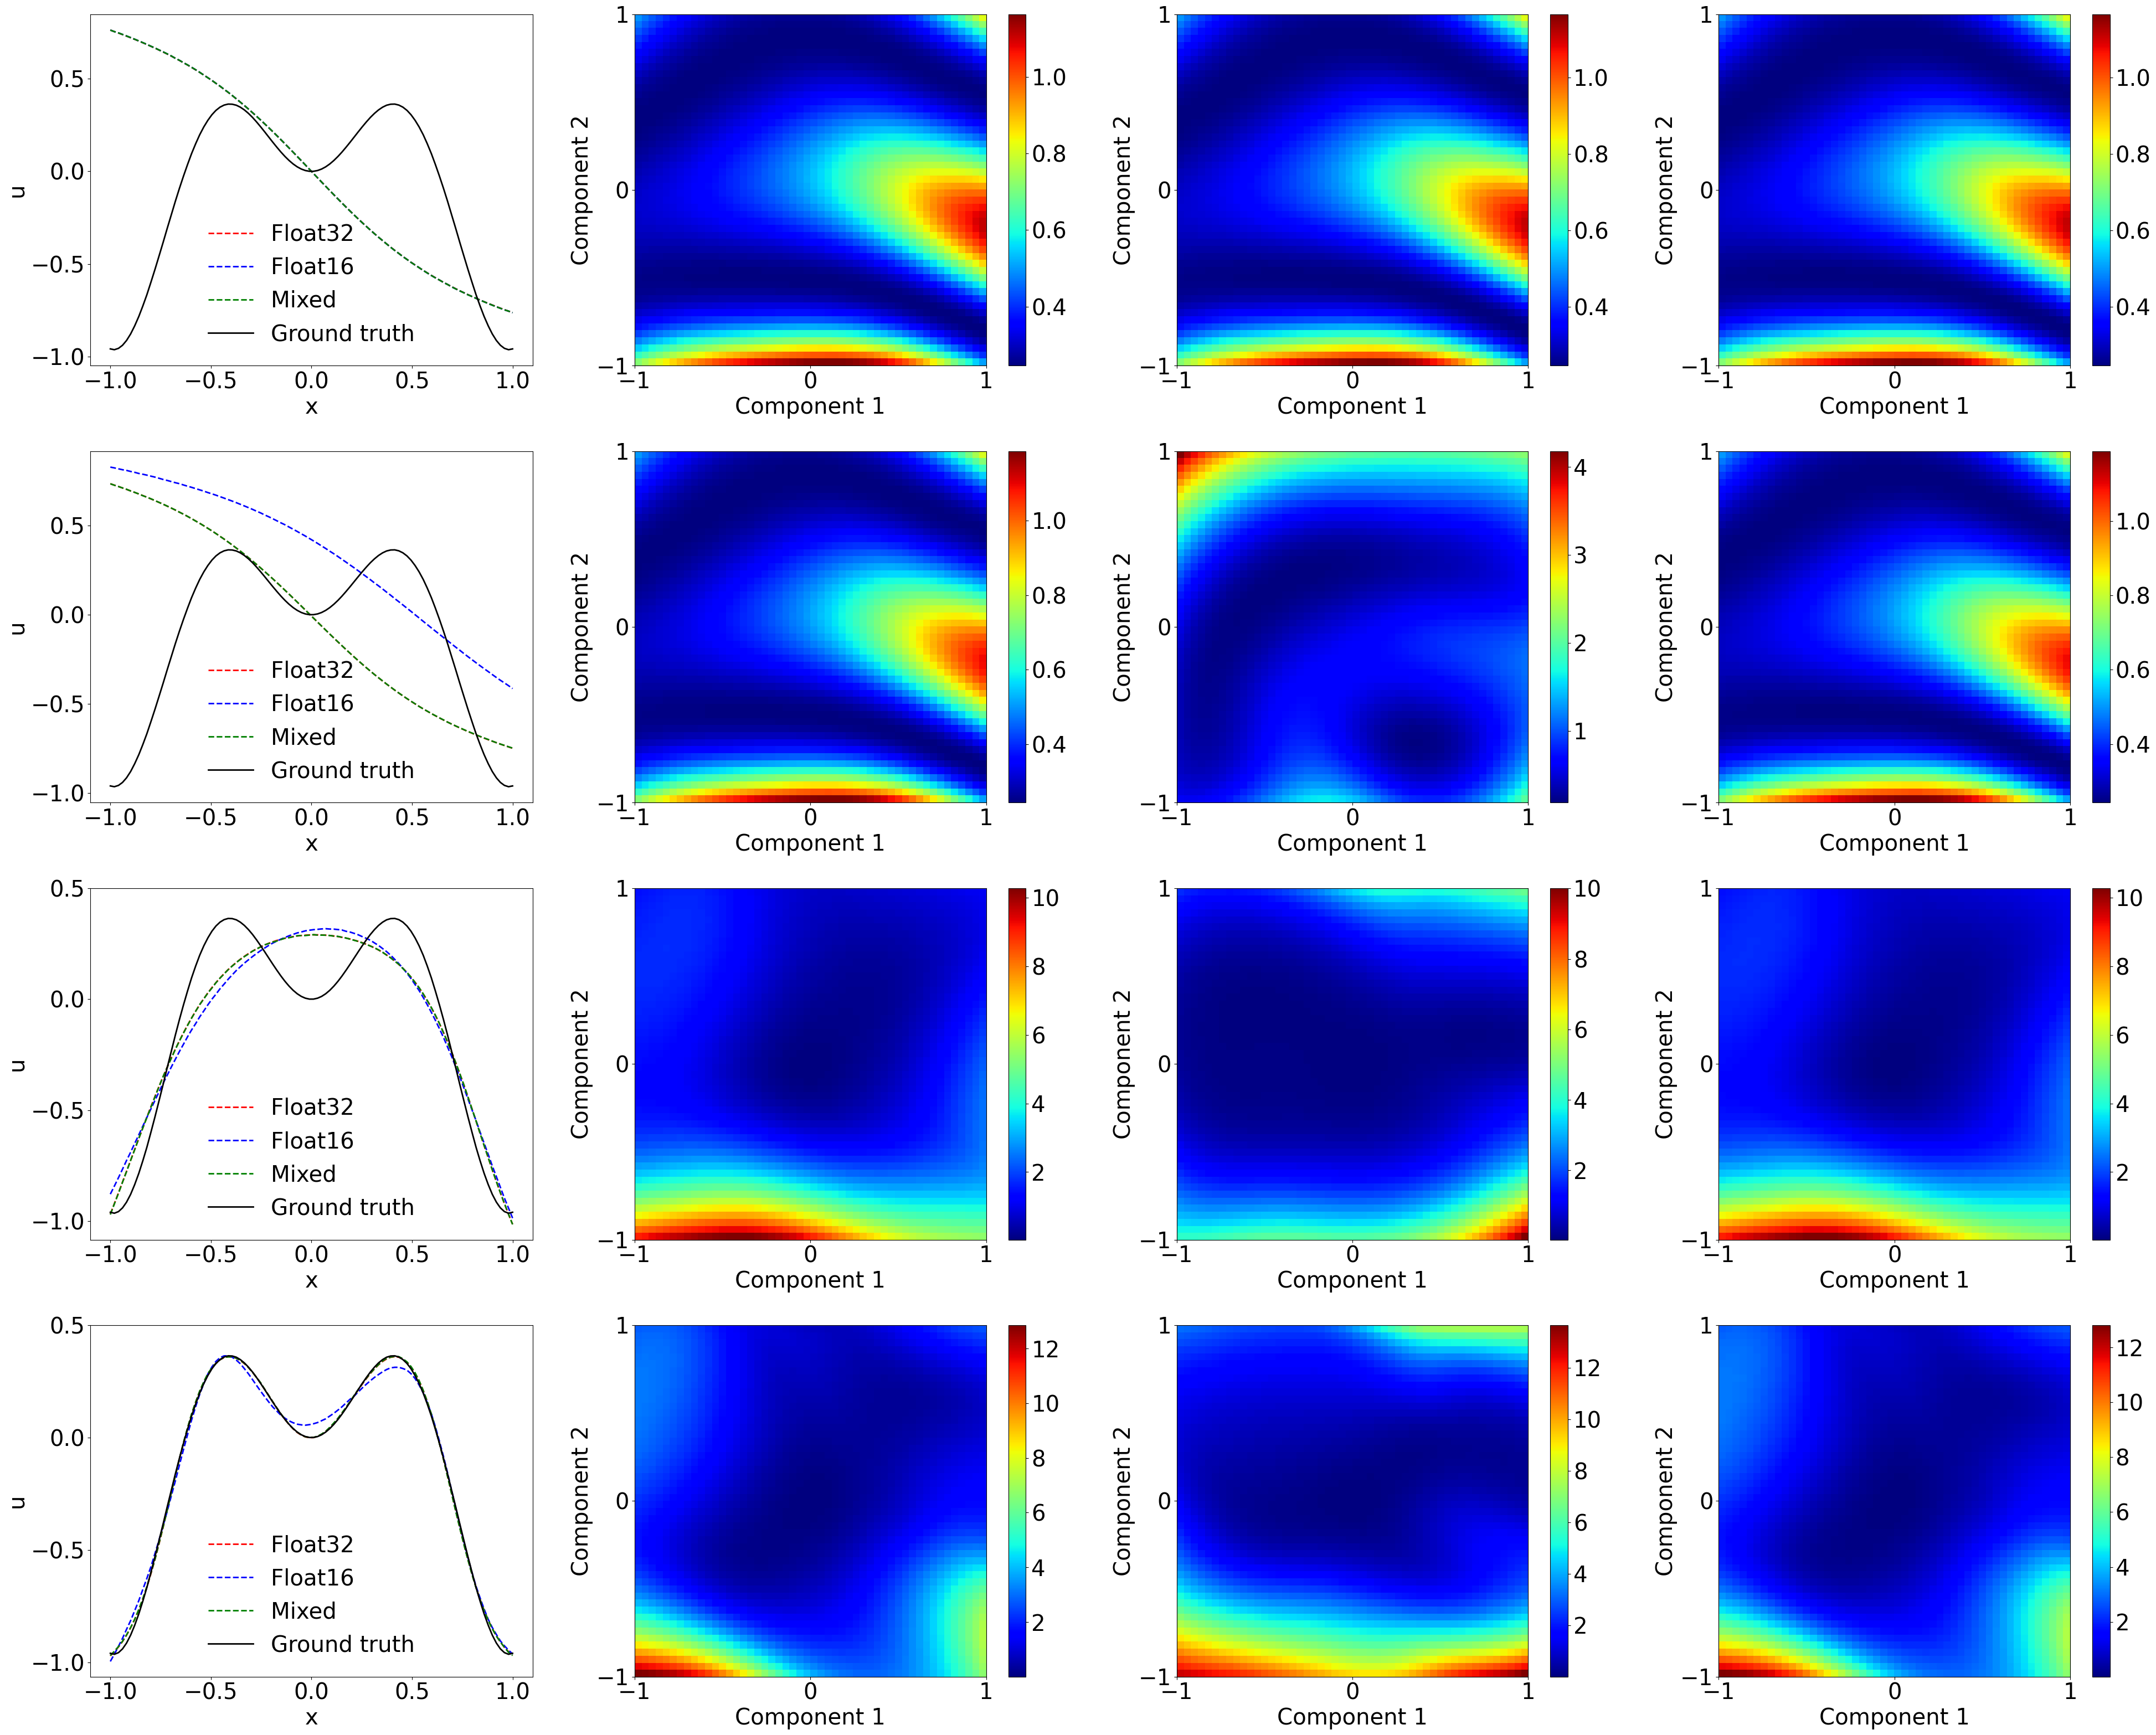

In [13]:
import matplotlib
import matplotlib.pyplot as plt
def fetch_test_and_predicted(filename):
    if filename[-5:] != ".hdf5":
        filename += ".hdf5"

    with h5py.File(filename, "r") as f:
        test, predicted = f['X_TEST'], f["Y_TEST_PREDICTED"]
        test_copy = np.array(test)
        predicted_copy = np.array(predicted)
    return test_copy, predicted_copy

files = list(zip(global_store["float 32"], global_store["float 16"], global_store["mixed float 16"]))
n_epochs = len(files)
n_types = len(files[0]) + 1  # additional column for the predicted values plot
matplotlib.rcParams.update({'font.size': 29})
fig, axes = plt.subplots(n_epochs, n_types, figsize=(40, n_epochs * 8))

for i, file_tuple in enumerate(files):
    for j, file in enumerate(file_tuple):
        ax = axes[i, j+1] if n_epochs > 1 else axes[j+1]  # shift to right for the predictions plot

        # plot data
        X, Y, Z = _fetch_data("MSE", file)
        im = ax.imshow(
            Z, interpolation="none", cmap='jet', extent=[X.min(), X.max(), Y.min(), Y.max()]
        )
        cbar = plt.colorbar(im, ax=ax)
        ax.set_xlabel("Component 1")
        ax.set_ylabel("Component 2")
        ax.set_xticks([-1, 0, 1])
        ax.set_yticks([-1, 0, 1])

        convert_filename_to_title = lambda filename: filename.split('/')[-1].split('.hdf5')[0].replace('_', ' ')
        titled_name = convert_filename_to_title(file)
        # ax.set_title(f"{titled_name}")
        rgb = [('Float32', 'r--'), ('Float16', 'b--'),('Mixed', 'g--')]
        # plot predictions at the beginning of each row
        test, predicted = fetch_test_and_predicted(file)
        ax_pred = axes[i, 0] if n_epochs > 1 else axes[0]  # position of the predictions plot
        ax_pred.plot(test, predicted, rgb[j][1], label=rgb[j][0], linewidth=2)
    # we plot the ground truth
    ax_pred = axes[i, 0] if n_epochs > 1 else axes[0]  # position of the predictions plot
    ax_pred.plot(model16_new.data.test_x, model16_new.data.test_y, 'k-', label='Ground truth', linewidth=2)
    ax_pred.set_yticks([-1, -.5, 0, .5])
    ax_pred.set_xticks([-1, -.5, 0, .5 ,1])
    ax_pred.set_xlabel('x')
    ax_pred.set_ylabel('u')
    ax_pred.legend(frameon=False, loc='lower center')

fig.patch.set_facecolor('white')
plt.tight_layout()
plt.savefig("llnotitle.pdf")
plt.show()